<a href="https://colab.research.google.com/github/coderxx-cpu/imagecaptioning/blob/main/inframind_image_description.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

In [1]:
!git clone https://github.com/coderxx-cpu/imagecaptioning.git

Cloning into 'imagecaptioning'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -uq "/content/drive/MyDrive/Colab Notebooks/Flickr8k_Dataset.zip" -d "/content/drive/MyDrive/Colab Notebooks/dataset"


In [ ]:
!unzip -uq "/content/drive/MyDrive/Colab Notebooks/Flickr8k_text.zip" -d "/content/drive/MyDrive/Colab Notebooks/text"

In [ ]:
from pickle import dump
from os import listdir
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

def extract_features(directory):
	model = VGG16()
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	print(model.summary())
	features = dict()
	for name in listdir(directory):
		filename = directory + '/' + name
		image = load_img(filename, target_size=(224, 224))
		image = img_to_array(image)
		image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    #image = image.reshape((1, 224*224*3))
		image = preprocess_input(image)
		feature = model.predict(image, verbose=0)
		image_id = name.split('.')[0]
		features[image_id] = feature
	return features
 
directory = '/content/drive/MyDrive/Colab Notebooks/dataset/Flicker8k_Dataset'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('features.pkl', 'wb'))


553467904/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
import string
def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text
 

def load_descriptions(doc):
	mapping = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		if len(line) < 2:
			continue
		image_id, image_desc = tokens[0], tokens[1:]
		image_id = image_id.split('.')[0]
		image_desc = ' '.join(image_desc)
		if image_id not in mapping:
			mapping[image_id] = list()
		mapping[image_id].append(image_desc)
	return mapping
 
def clean_descriptions(descriptions):
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			desc = desc.split()
			desc = [word.lower() for word in desc]
			desc = [w.translate(table) for w in desc]
			desc = [word for word in desc if len(word)>1]
			desc = [word for word in desc if word.isalpha()]
			desc_list[i] =  ' '.join(desc)
 
def to_vocabulary(descriptions):
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc
 
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()
 
filename = '/content/drive/MyDrive/Colab Notebooks/text/Flickr8k.token.txt'
doc = load_doc(filename)
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
clean_descriptions(descriptions)
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))
save_descriptions(descriptions, 'descriptions.txt')

Loaded: 8092 
Vocabulary Size: 8763


In [ ]:
from numpy import array
from pickle import load
from pickle import dump
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text
 

def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	for line in doc.split('\n'):
		if len(line) < 1:
			continue
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)
 
def load_clean_descriptions(filename, dataset):
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		image_id, image_desc = tokens[0], tokens[1:]
		if image_id in dataset:
			if image_id not in descriptions:
				descriptions[image_id] = list()
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			descriptions[image_id].append(desc)
	return descriptions
 
def load_photo_features(filename, dataset):
	all_features = load(open(filename, 'rb'))
	features = {k: all_features[k] for k in dataset}
	return features
 
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc
 
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

In [ ]:
from pickle import dump


def create_sequences(tokenizer, max_length, descriptions, photos):
	X1, X2, y = list(), list(), list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			seq = tokenizer.texts_to_sequences([desc])[0]
			for i in range(1, len(seq)):
				in_seq, out_seq = seq[:i], seq[i]
				in_seq = pad_sequences([in_seq], maxlen=max_length)[0])
				out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
				X1.append(photos[key][0])
				X2.append(in_seq)
				y.append(out_seq)
	return array(X1), array(X2), array(y)
 
# load training dataset
filename = '/content/drive/MyDrive/Colab Notebooks/text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.pkl', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features)
 


Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 7579
Description Length: 34


In [ ]:

 
# load test set
filename = '/content/drive/MyDrive/Colab Notebooks/text/Flickr_8k.devImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))
X1test, X2test, ytest = create_sequences(tokenizer, max_length, test_descriptions, test_features)



Dataset: 1000
Descriptions: test=1000
Photos: test=1000


In [ ]:

def define_model(vocab_size, max_length):
    inputs1 = Input(shape=(1000,))
    fe1 = Dropout(0.3)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.3)(se1)
    
    
    merge = add([fe2, se2])
    decoder1 = LSTM(256)(merge)
  
    decoder2 = Dense(256, activation='relu')(decoder1)
    bn = BatchNormalization()(decoder2)
    do = Dropout(0.1)(bn)
    decoder3 = Dense(512, activation='relu')(do)
    bn = BatchNormalization()(decoder3)
    do = Dropout(0.1)(bn)
    outputs = Dense(vocab_size, activation='softmax')(do)
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    print(model.summary())
    return model
 
model = define_model(vocab_size, max_length)
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.fit([X1train, X2train], ytrain, epochs=20, verbose=2, callbacks=[checkpoint], validation_data=([X1test, X2test], ytest))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1000)         0           input_2[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 256)      1940224     input_3[0][0]                    
____________________________________________________________________________________________

In [ ]:
from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

def generate_desc(model, tokenizer, photo, max_length):
	in_text = 'startseq'
	for i in range(max_length):
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		sequence = pad_sequences([sequence], maxlen=max_length)
		yhat = model.predict([photo,sequence], verbose=0)
		yhat = argmax(yhat)
		word = word_for_id(yhat, tokenizer)
		if word is None:
			break
		in_text += ' ' + word
		if word == 'endseq':
			break
	return in_text

def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
 

def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	for key, desc_list in descriptions.items():
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)
 

BLEU-1: 0.514915
BLEU-2: 0.281204
BLEU-3: 0.202472
BLEU-4: 0.104100


 brown dog is running through the grass 


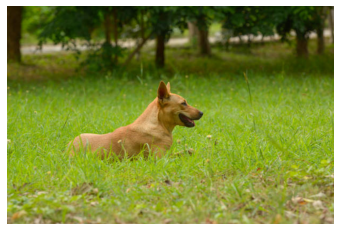

 man in blue shirt and blue shirt is running with his hands in the air 


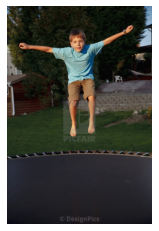

 two people are walking on the beach 


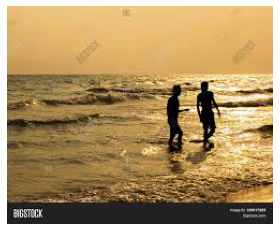

In [ ]:
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model
from pickle import load
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

def generate_desc(model, tokenizer, photo, max_length):
	in_text = 'startseq'
	for i in range(max_length):
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		sequence = pad_sequences([sequence], maxlen=max_length)
		yhat = model.predict([photo,sequence], verbose=0)
		yhat = argmax(yhat)
		word = word_for_id(yhat, tokenizer)
		if word is None:
			break
		in_text += ' ' + word
		if word == 'endseq':
			break
	return in_text
 
def extract_features(filename):
  model = VGG16()
  model.layers.pop()
  model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
  image = load_img(filename, target_size=(224, 224))
  image = img_to_array(image)
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  image = preprocess_input(image)
  feature = model.predict(image, verbose=0)
  del model
  return feature
 

def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
 

tokenizer = load(open('tokenizer.pkl', 'rb'))
max_length = 34
model = load_model('model-ep004-loss3.217-val_loss3.446.h5')
photos = ['/content/drive/MyDrive/Colab Notebooks/example7.jpg','/content/drive/MyDrive/Colab Notebooks/example4.jpg','/content/drive/MyDrive/Colab Notebooks/example13.jpg']
for fname in photos:
  photo = extract_features(fname)
  
  description = generate_desc(model, tokenizer, photo, max_length)
  print(description[8:-6])
  img=mpimg.imread(fname)
  imgplot = plt.imshow(img)
  plt.axis('off')

  plt.show()
del model